In [31]:
import pyodbc
import pandas as pd
import numpy as np
import os
import logging

In [32]:
import pandas as pd
import pyodbc
import logging
import os
from functools import reduce

# Configura logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Configuración de conexión
AZURE_SERVER = 'uaxmathfis.database.windows.net'
AZURE_DATABASE = 'usecases'
AZURE_DRIVER = '{ODBC Driver 17 for SQL Server}'
CSV_PATH = 'datos_combinados.csv'

def get_azure_connection():
    """Establece conexión con Azure SQL usando autenticación interactiva"""
    conn_str = f"DRIVER={AZURE_DRIVER};SERVER={AZURE_SERVER};DATABASE={AZURE_DATABASE};Authentication=ActiveDirectoryInteractive"
    try:
        conn = pyodbc.connect(conn_str)
        logging.info("Conexión exitosa a Azure SQL")
        return conn
    except Exception as e:
        logging.error(f"Error de conexión: {e}")
        return None

def download_and_combine_tables():
    """Descarga todas las tablas y las combina correctamente por fecha"""
    # Eliminar el archivo CSV si existe
    if os.path.exists(CSV_PATH):
        try:
            os.remove(CSV_PATH)
            logging.info(f"Archivo existente {CSV_PATH} eliminado")
        except Exception as e:
            logging.error(f"No se pudo eliminar {CSV_PATH}: {e}")

    queries = {
        'MMM01_WEB': "SELECT * FROM DATAEX.MMM01_WEB",
        'MMM02_VISIT': "SELECT * FROM DATAEX.MMM02_VISIT",
        'MMM03_OFFLINE': "SELECT * FROM DATAEX.MMM03_OFFLINE",
        'MMM04_TIME': "SELECT * FROM DATAEX.MMM04_TIME",
        'MMM05_INV': "SELECT * FROM DATAEX.MMM05_INV"
    }

    conn = get_azure_connection()
    if not conn:
        return pd.DataFrame()

    try:
        # Descargar todas las tablas
        dfs = {}
        for name, query in queries.items():
            try:
                df = pd.read_sql(query, conn)
                if 'ID_Date' in df.columns:
                    df['ID_Date'] = pd.to_datetime(df['ID_Date'].astype(str), format=('%Y%m'))
                    df = df.drop_duplicates(subset=['ID_Date'])
                    # Agregamos el nombre de la tabla como prefijo a las columnas
                    df.columns = [f'{name}_{col}' if col != 'ID_Date' else col for col in df.columns]
                    dfs[name] = df.set_index('ID_Date')
                    logging.info(f"Tabla {name} descargada ({len(df)} registros)")
                else:
                    logging.warning(f"Tabla {name} no tiene columna ID_Date")
            except Exception as e:
                logging.error(f"Error procesando {name}: {e}")

        # Combinar horizontalmente por fecha
        if dfs:
            # Fusionar todas las tablas usando merge secuencial
            combined = reduce(lambda left, right: pd.merge(
                left, right, 
                left_index=True, right_index=True, 
                how='outer'
            ), dfs.values())
            
            # Guardar a CSV (se creará nuevo archivo)
            combined.to_csv(CSV_PATH)
            logging.info(f"Nuevo archivo {CSV_PATH} creado ({len(combined)} registros combinados)")
            return combined
        else:
            logging.warning("No se descargaron datos válidos")
            return pd.DataFrame()

    finally:
        conn.close()

def load_from_csv():
    """Carga los datos previamente guardados desde el CSV"""
    try:
        if os.path.exists(CSV_PATH):
            return pd.read_csv(CSV_PATH, parse_dates=['ID_Date'], index_col='ID_Date')
        else:
            logging.warning(f"Archivo {CSV_PATH} no encontrado")
            return pd.DataFrame()
    except Exception as e:
        logging.error(f"Error cargando CSV: {e}")
        return pd.DataFrame()

# Ejecutar la descarga (siempre creará nuevo archivo)
df = download_and_combine_tables()

# Para cargar los datos posteriormente (si el archivo existe)
# df = load_from_csv()

if not df.empty:
    print("\nDatos combinados correctamente:")
    print(f"Total de registros: {len(df)}")
    print(f"Columnas: {len(df.columns)}")
    print("\nPrimeras filas:")
    df.head()
else:
    print("No hay datos disponibles")

2025-04-04 18:02:13,838 - INFO - Conexión exitosa a Azure SQL
2025-04-04 18:02:13,974 - INFO - Tabla MMM01_WEB descargada (36 registros)
2025-04-04 18:02:14,076 - INFO - Tabla MMM02_VISIT descargada (36 registros)
2025-04-04 18:02:14,172 - INFO - Tabla MMM03_OFFLINE descargada (36 registros)
2025-04-04 18:02:14,250 - INFO - Tabla MMM04_TIME descargada (36 registros)
2025-04-04 18:02:14,372 - INFO - Tabla MMM05_INV descargada (36 registros)
2025-04-04 18:02:14,379 - INFO - Nuevo archivo datos_combinados.csv creado (36 registros combinados)



Datos combinados correctamente:
Total de registros: 36
Columnas: 46

Primeras filas:


In [33]:
df = load_from_csv()
df = df.reset_index()

df

,ID_Date,MMM01_WEB_Unique_visitors,MMM01_WEB_PDFBrochuresDownloaded,MMM01_WEB_ProductConfigurator,MMM01_WEB_Product_configurator_Visists,MMM01_WEB_SocialNetworks,MMM01_WEB_DirectTraffic,MMM01_WEB_EMail,MMM01_WEB_NaturalSearch,MMM01_WEB_OnlineMedia,...,MMM05_INV_CINE,MMM05_INV_EXTERIOR,MMM05_INV_INTERNET,MMM05_INV_PRENSA,MMM05_INV_PRODUCCION,MMM05_INV_RADIO,MMM05_INV_REVISTAS,MMM05_INV_PlataformasVideo,MMM05_INV_VARIOS,MMM05_INV_INV_Total
0,2022-01-01,272382,4838,33222,94248,1415,65373,25,167199,63649,...,59887.840,8200.00,133666.43000,0.00000,6050.00,2426.40,18013.5000,338824.940,7531.0300,5.746001e+05
1,2022-02-01,352581,5823,38570,109531,546,77209,26,176733,124861,...,72291.560,94627.51,189275.94000,10000.00000,6700.00,0.00,49110.9100,487537.140,6972.0200,9.165151e+05
2,2022-03-01,332955,4845,33956,97805,5444,83178,341,173514,104132,...,55000.000,0.00,214037.62000,4500.00000,3700.00,0.00,0.0000,75000.000,15284.8500,3.675225e+05
3,2022-04-01,282169,3711,45949,90689,1184,69335,162,162805,74044,...,10883.300,0.00,194816.97000,48800.00000,21550.00,1140.00,40876.0000,610865.890,12255.7500,9.411879e+05
4,2022-05-01,261829,9037,48685,92069,8648,70972,210,156011,44196,...,74333.200,0.00,130795.16000,11000.00000,4900.00,102851.86,20775.7500,393807.740,7926.4600,7.463902e+05
5,2022-06-01,201141,10727,38608,73421,1082,61455,2374,134355,15600,...,37400.000,0.00,67827.66000,0.00000,12250.00,5526.49,75573.1300,0.000,5405.7200,2.039830e+05
6,2022-07-01,206538,11023,38912,74564,909,66835,204,144300,11000,...,58816.500,0.00,61897.17000,0.00000,650.00,158.40,2600.0000,1500.000,4574.5000,1.301966e+05
7,2022-08-01,259903,15743,47613,88335,7511,78704,14,172986,15205,...,0.000,0.00,46362.01000,13000.00000,9750.00,345.60,33860.0000,391987.870,28716.2600,5.240217e+05
8,2022-09-01,261618,14130,44164,83840,1773,58630,199,174125,41832,...,39483.300,0.00,77470.41000,9507.80000,7850.00,2686.80,14580.0000,0.000,6645.2700,1.582236e+05
9,2022-10-01,396642,16321,53200,100262,2117,74040,874,203699,162588,...,45733.200,0.00,271750.66000,0.00000,20300.00,3162.00,117786.9700,804181.400,14421.1300,1.277335e+06


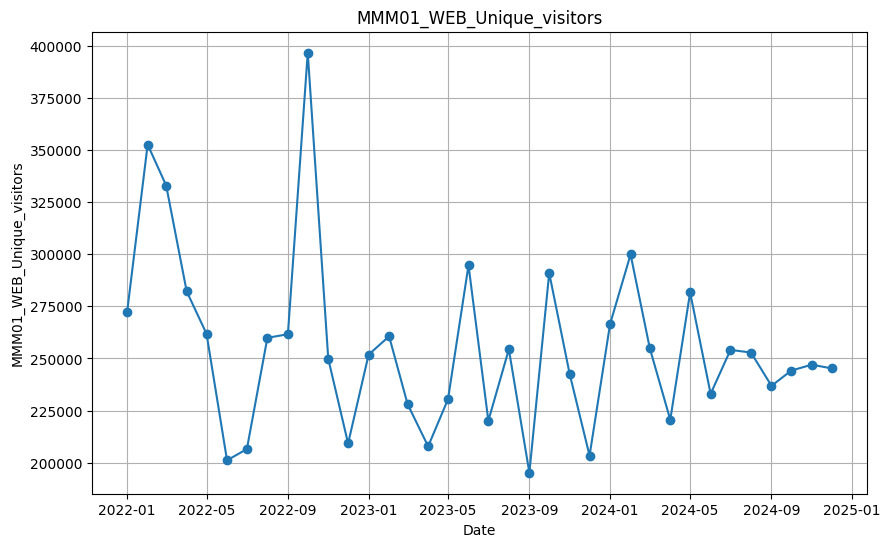

In [34]:
import matplotlib.pyplot as plt

# Convertir la columna 'Date' a tipo datetime y establecerla como índice
df['ID_Date'] = pd.to_datetime(df['ID_Date'], format='%d.%m.%Y')
df.set_index('ID_Date', inplace=True)

# Convertir los datos diarios a datos mensuales tomando el primer día de cada mes
df_monthly = df.resample('MS').mean().asfreq('MS')

# Filtrar todas las filas donde 'Revenue' no sea nulo o NaN
df_monthly_filtered = df_monthly.dropna(subset=['MMM01_WEB_Unique_visitors'])

# Graficar la columna 'Revenue'
plt.figure(figsize=(10, 6))
plt.plot(df_monthly_filtered.index, df_monthly_filtered['MMM01_WEB_Unique_visitors'], marker='o', linestyle='-')
plt.title('MMM01_WEB_Unique_visitors')
plt.xlabel('Date')
plt.ylabel('MMM01_WEB_Unique_visitors')
plt.grid(True)
plt.show()

In [35]:
# Dividir los datos con solapamiento (80% entrenamiento, 23% prueba con 3% de solapamiento)
train_size = int(len(df_monthly_filtered) * 0.80)
test_size = int(len(df_monthly_filtered) * 0.23)  

# Asegurarnos de no exceder el tamaño del dataframe
test_size = min(test_size, len(df_monthly_filtered) - train_size + int(len(df_monthly_filtered)*0.03))

train = df_monthly_filtered.iloc[:train_size]
test = df_monthly_filtered.iloc[train_size - int(len(df_monthly_filtered)*0.03):train_size + test_size]

Top 5 Modelos SARIMA basados en AIC:
       order seasonal_order         aic         bic          rmse         r2
0  (1, 2, 2)  (0, 1, 1, 12)  348.804724  352.000011  63529.735895 -14.889747
1  (1, 2, 2)  (1, 1, 0, 12)  349.884806  353.080092  67764.123788 -17.078506
2  (0, 2, 2)  (0, 1, 1, 12)  349.917446  352.473676  53912.433162 -10.443022
3  (0, 2, 1)  (0, 1, 1, 12)  350.468198  352.385370  50696.621185  -9.118611
4  (0, 2, 2)  (1, 1, 0, 12)  350.553361  353.109590  57426.250827 -11.983262


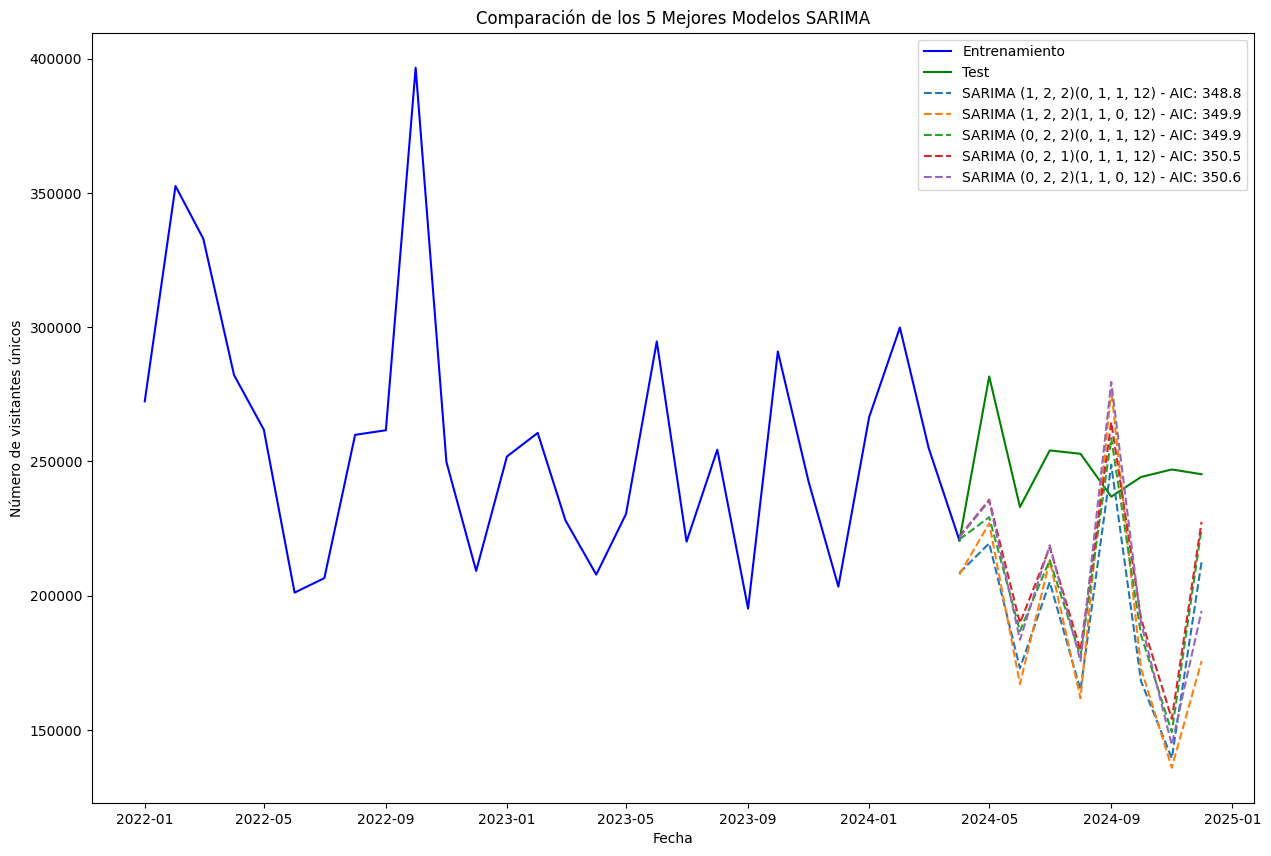

ValueError: x and y must have same first dimension, but have shapes (9,) and (10,)

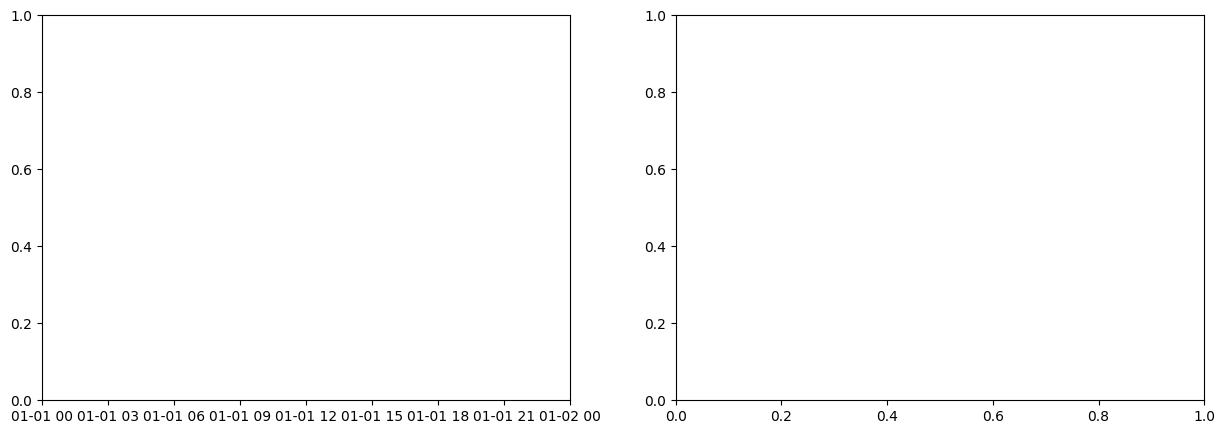

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from itertools import product

# Función para calcular métricas
def calcular_metricas(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, rmse, r2

# Función para evaluar modelo SARIMA
def evaluar_sarima(train_data, test_data, order, seasonal_order):
    try:
        # Ajustar el modelo
        model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
        model_fit = model.fit(disp=False)
        
        # Predecir
        predictions = model_fit.get_prediction(start=len(train_data), 
                                              end=len(train_data) + len(test_data) - 1)
        pred_mean = predictions.predicted_mean
        
        # Calcular métricas
        metrics = calcular_metricas(test_data, pred_mean)
        
        return {
            'order': order,
            'seasonal_order': seasonal_order,
            'aic': model_fit.aic,
            'bic': model_fit.bic,
            'mse': metrics[0],
            'mae': metrics[1],
            'rmse': metrics[2],
            'r2': metrics[3],
            'model': model_fit
        }
    except:
        return None

# Rangos de parámetros a probar
p = d = q = range(0, 3)  # Parámetros no estacionales
P = D = Q = range(0, 2)  # Parámetros estacionales
m = 12  # Estacionalidad mensual (12 meses)

# Generar todas las combinaciones posibles
param_combinations = list(product(p, d, q, P, D, Q))

results = []

# Probar cada combinación de parámetros
for params in param_combinations:
    order = (params[0], params[1], params[2])
    seasonal_order = (params[3], params[4], params[5], m)
    
    # Evaluar el modelo
    result = evaluar_sarima(train['MMM01_WEB_Unique_visitors'], 
                           test['MMM01_WEB_Unique_visitors'], 
                           order, seasonal_order)
    
    if result is not None:
        results.append(result)

# Convertir a DataFrame y ordenar por AIC (mejores modelos primero)
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='aic').reset_index(drop=True)

# Seleccionar los 5 mejores modelos
top_5_models = results_df.head(5)

# Mostrar los 5 mejores modelos
print("Top 5 Modelos SARIMA basados en AIC:")
print(top_5_models[['order', 'seasonal_order', 'aic', 'bic', 'rmse', 'r2']])

# Graficar las predicciones de los mejores modelos
plt.figure(figsize=(15, 10))
plt.plot(train.index, train['MMM01_WEB_Unique_visitors'], label='Entrenamiento', color='blue')
plt.plot(test.index, test['MMM01_WEB_Unique_visitors'], label='Test', color='green')

for i, model_info in top_5_models.iterrows():
    predictions = model_info['model'].get_prediction(
        start=len(train), 
        end=len(train) + len(test) - 1
    ).predicted_mean
    
    plt.plot(test.index, predictions, 
             label=f'SARIMA {model_info["order"]}{model_info["seasonal_order"]} - AIC: {model_info["aic"]:.1f}',
             linestyle='--')

plt.xlabel('Fecha')
plt.ylabel('Número de visitantes únicos')
plt.title('Comparación de los 5 Mejores Modelos SARIMA')
plt.legend()
plt.show()

# Función para graficar residuos
def plot_residuals(test_data, predictions, title):
    residuals = test_data - predictions
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Gráfico de series temporales de residuos
    axes[0].plot(test_data.index, residuals)
    axes[0].axhline(y=0, color='r', linestyle='--')
    axes[0].set_title(f'Residuos - {title}')
    axes[0].set_xlabel('Fecha')
    axes[0].set_ylabel('Residuos')
    
    # Histograma de residuos
    axes[1].hist(residuals, bins=20)
    axes[1].set_title(f'Distribución de Residuos - {title}')
    axes[1].set_xlabel('Residuos')
    axes[1].set_ylabel('Frecuencia')
    
    plt.tight_layout()
    plt.show()

# Graficar residuos para los mejores modelos
for i, model_info in top_5_models.iterrows():
    predictions = model_info['model'].get_prediction(
        start=len(train), 
        end=len(train) + len(test) - 1
    ).predicted_mean
    
    plot_residuals(test['MMM01_WEB_Unique_visitors'], predictions, 
                  f'SARIMA {model_info["order"]}{model_info["seasonal_order"]}')

# Mostrar resumen de los mejores modelos
for i, model_info in top_5_models.iterrows():
    print(f"\nModelo {i+1}: SARIMA{model_info['order']}{model_info['seasonal_order']}")
    print("="*60)
    print(model_info['model'].summary())
    print("\nMétricas:")
    print(f"AIC: {model_info['aic']:.2f}")
    print(f"BIC: {model_info['bic']:.2f}")
    print(f"RMSE: {model_info['rmse']:.2f}")
    print(f"R²: {model_info['r2']:.2f}") 

Top 5 Modelos SARIMA basados en AIC:
       order seasonal_order         aic         bic          rmse         r2
0  (1, 2, 2)  (0, 1, 1, 12)  348.804724  352.000011  68025.743731 -22.889034
1  (1, 2, 2)  (1, 1, 0, 12)  349.884806  353.080092  69609.461768 -24.014311
2  (0, 2, 2)  (0, 1, 1, 12)  349.917446  352.473676  57627.504368 -16.143979
3  (0, 2, 1)  (0, 1, 1, 12)  350.468198  352.385370  54754.588659 -14.477223
4  (0, 2, 2)  (1, 1, 0, 12)  350.553361  353.109590  59309.729559 -17.159500


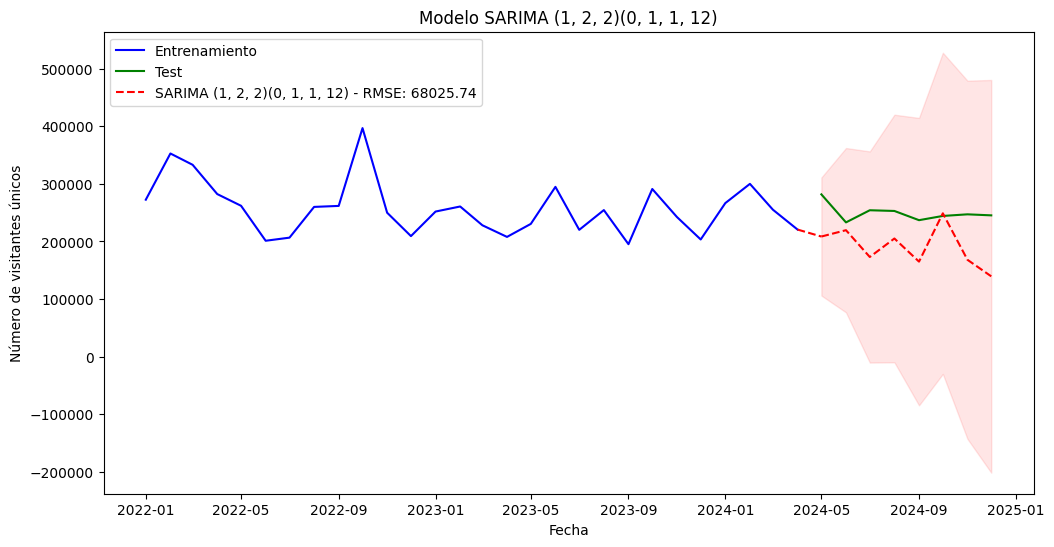

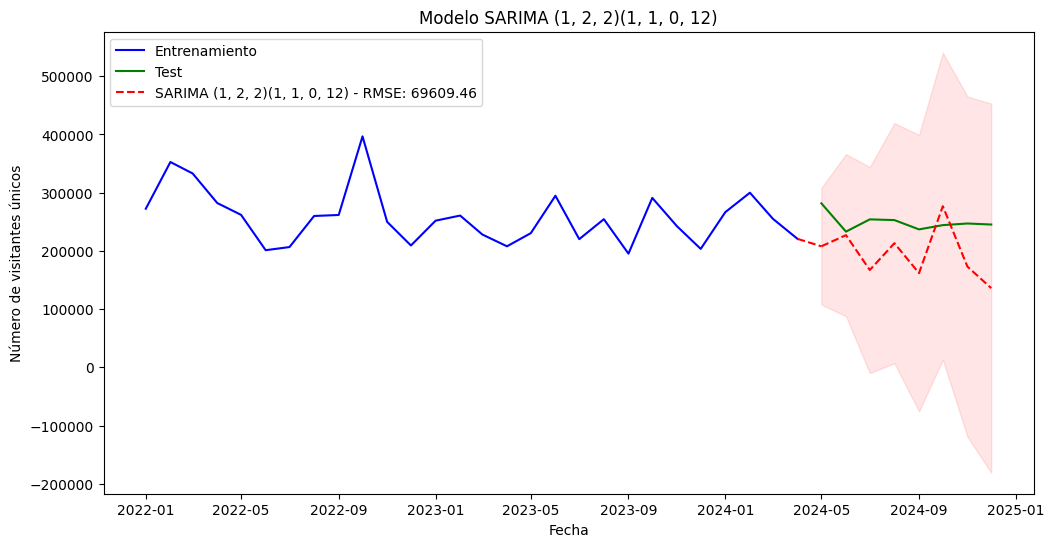

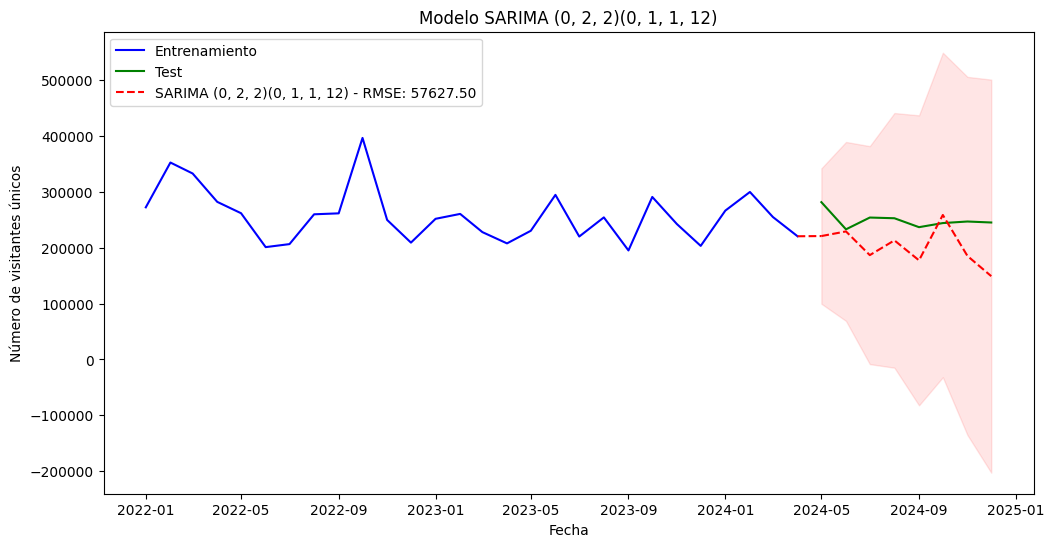

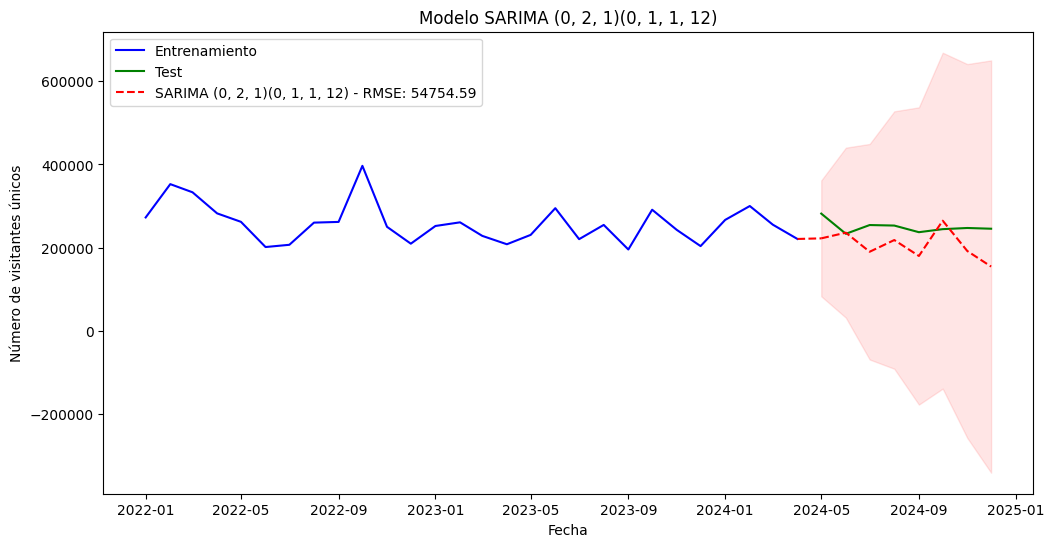

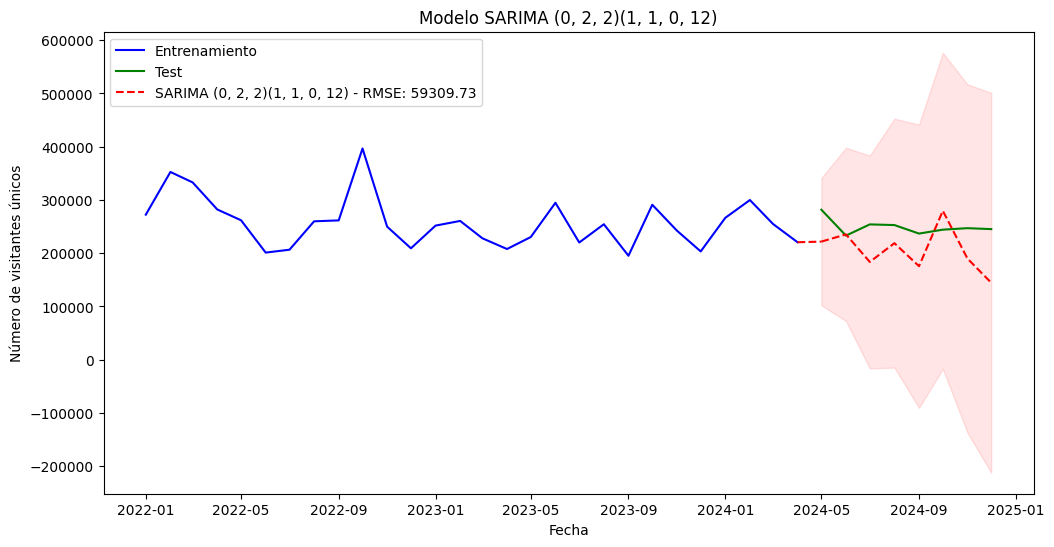


Modelo 1: SARIMA(1, 2, 2)(0, 1, 1, 12)
                                      SARIMAX Results                                       
Dep. Variable:            MMM01_WEB_Unique_visitors   No. Observations:                   28
Model:             SARIMAX(1, 2, 2)x(0, 1, [1], 12)   Log Likelihood                -169.402
Date:                             vi., 04 abr. 2025   AIC                            348.805
Time:                                      17:05:56   BIC                            352.000
Sample:                                  01-01-2022   HQIC                           348.509
                                       - 04-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9488      0.740     -1.282      0.200    

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from itertools import product

# Función para calcular métricas
def calcular_metricas(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, rmse, r2

# Función para evaluar modelo SARIMA con transición suave
def evaluar_sarima(train_data, test_data, order, seasonal_order):
    try:
        # Ajustar el modelo
        model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
        model_fit = model.fit(disp=False)
        
        # Predecir incluyendo el punto de transición
        forecast = model_fit.get_forecast(steps=len(test_data))
        pred_mean = forecast.predicted_mean
        conf_int = forecast.conf_int()
        
        # Calcular métricas
        metrics = calcular_metricas(test_data, pred_mean)
        
        return {
            'order': order,
            'seasonal_order': seasonal_order,
            'aic': model_fit.aic,
            'bic': model_fit.bic,
            'mse': metrics[0],
            'mae': metrics[1],
            'rmse': metrics[2],
            'r2': metrics[3],
            'model': model_fit,
            'predictions': pred_mean,
            'conf_int': conf_int
        }
    except Exception as e:
        print(f"Error con {order}{seasonal_order}: {str(e)}")
        return None

# Función para graficar con transición suave
def plot_model_with_transition(train_data, test_data, model_result):
    plt.figure(figsize=(12, 6))
    
    # Graficar datos reales
    plt.plot(train_data.index, train_data, label='Entrenamiento', color='blue')
    plt.plot(test_data.index, test_data, label='Test', color='green')
    
    # Obtener predicciones
    pred_mean = model_result['predictions']
    conf_int = model_result['conf_int']
    
    # Graficar predicción con intervalo de confianza
    plt.plot(test_data.index, pred_mean, linestyle='--', color='red',
             label=f'SARIMA {model_result["order"]}{model_result["seasonal_order"]} - RMSE: {model_result["rmse"]:.2f}')
    plt.fill_between(test_data.index, 
                    conf_int.iloc[:, 0], 
                    conf_int.iloc[:, 1], 
                    color='red', alpha=0.1)
    
    # Conectar último punto de entrenamiento con primera predicción
    plt.plot([train_data.index[-1], test_data.index[0]], 
             [train_data.iloc[-1], pred_mean.iloc[0]], 
             linestyle='--', color='red')
    
    plt.xlabel('Fecha')
    plt.ylabel('Número de visitantes únicos')
    plt.title(f'Modelo SARIMA {model_result["order"]}{model_result["seasonal_order"]}')
    plt.legend()
    plt.show()

# Rangos de parámetros a probar
p = d = q = range(0, 3)  # Parámetros no estacionales
P = D = Q = range(0, 2)  # Parámetros estacionales
m = 12  # Estacionalidad mensual

# Generar todas las combinaciones posibles
param_combinations = list(product(p, d, q, P, D, Q))

results = []

# Probar cada combinación de parámetros
for params in param_combinations:
    order = (params[0], params[1], params[2])
    seasonal_order = (params[3], params[4], params[5], m)
    
    result = evaluar_sarima(train['MMM01_WEB_Unique_visitors'], 
                          test['MMM01_WEB_Unique_visitors'], 
                          order, seasonal_order)
    if result is not None:
        results.append(result)

# Convertir a DataFrame y ordenar por AIC
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='aic').reset_index(drop=True)

# Seleccionar los 5 mejores modelos
top_5_models = results_df.head(5)

# Mostrar los 5 mejores modelos
print("Top 5 Modelos SARIMA basados en AIC:")
print(top_5_models[['order', 'seasonal_order', 'aic', 'bic', 'rmse', 'r2']])

# Graficar cada modelo con transición suave
for i, model_info in top_5_models.iterrows():
    plot_model_with_transition(train['MMM01_WEB_Unique_visitors'],
                             test['MMM01_WEB_Unique_visitors'],
                             model_info)

# Mostrar resumen de los mejores modelos
for i, model_info in top_5_models.iterrows():
    print(f"\nModelo {i+1}: SARIMA{model_info['order']}{model_info['seasonal_order']}")
    print("="*60)
    print(model_info['model'].summary())
    print("\nMétricas:")
    print(f"AIC: {model_info['aic']:.2f}")
    print(f"BIC: {model_info['bic']:.2f}")
    print(f"RMSE: {model_info['rmse']:.2f}")
    print(f"R²: {model_info['r2']:.2f}")

Métricas del Modelo SARIMA (0, 3, 0)(0, 1, 1, 12): (4036027342.8929443, 55498.025075212936, 63529.73589503536, -14.889747043210273)


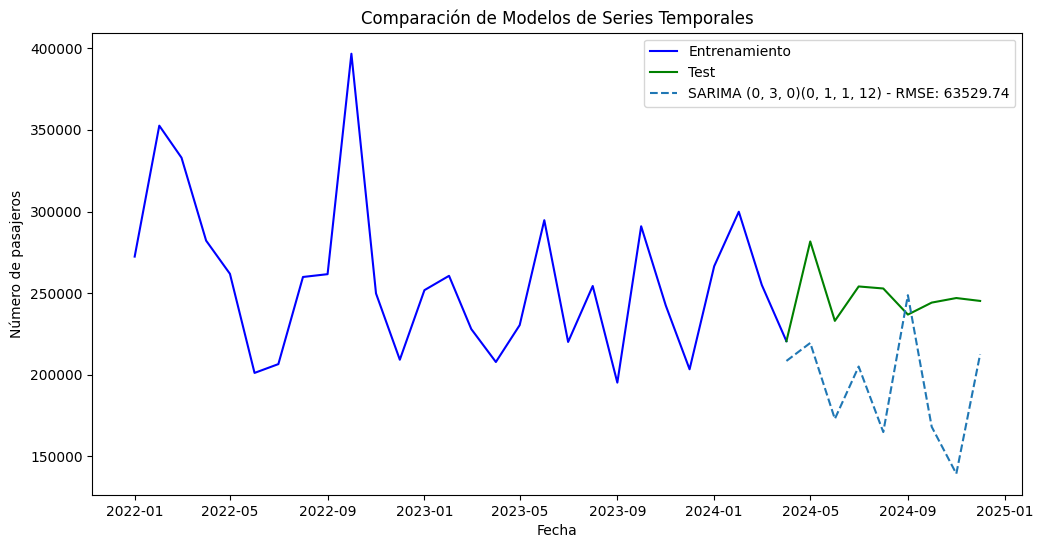

ARIMA - AIC: 348.80472388285153 BIC: 352.00001053092785
SARIMA - AIC: 348.80472388285153 BIC: 352.00001053092785

Coeficientes SARIMA (0, 3, 0)(0, 1, 1, 12):
                                      SARIMAX Results                                       
Dep. Variable:            MMM01_WEB_Unique_visitors   No. Observations:                   28
Model:             SARIMAX(1, 2, 2)x(0, 1, [1], 12)   Log Likelihood                -169.402
Date:                             vi., 04 abr. 2025   AIC                            348.805
Time:                                      17:34:06   BIC                            352.000
Sample:                                  01-01-2022   HQIC                           348.509
                                       - 04-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------

ValueError: x and y must have same first dimension, but have shapes (9,) and (10,)

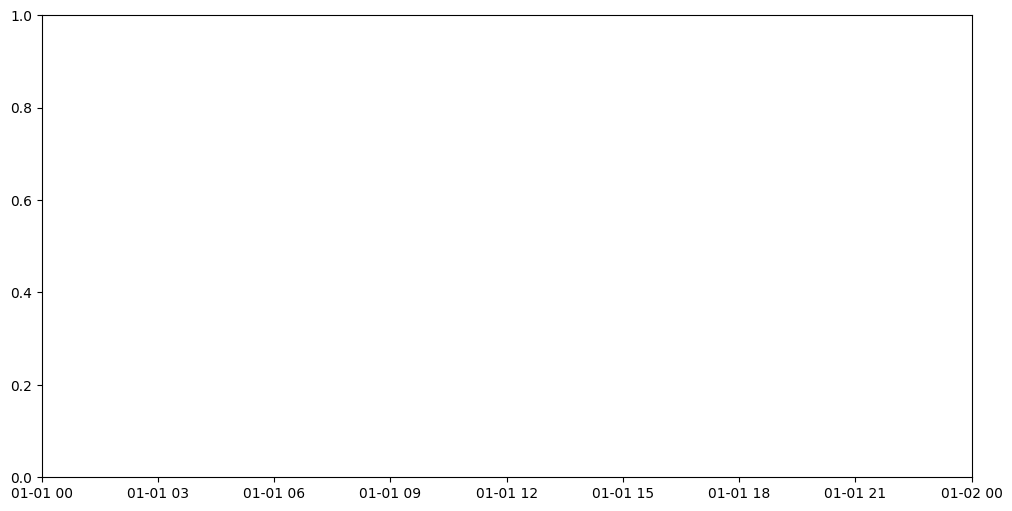

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ARIMA, SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Ajustar y predecir el modelo SARIMA
sarima_model2 = SARIMAX(train['MMM01_WEB_Unique_visitors'], order=(1, 2, 2), seasonal_order=(0, 1, 1, 12))
sarima_fit2 = sarima_model2.fit()
sarima_predictions2 = sarima_fit2.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')

# Calcular métricas de validación para cada modelo
def calcular_metricas(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, rmse, r2

# Calculamos las métricas para cada modelo

sarima_metrics2 = calcular_metricas(test['MMM01_WEB_Unique_visitors'], sarima_predictions2)

# Imprimir las métricas

print("Métricas del Modelo SARIMA (0, 3, 0)(0, 1, 1, 12):", sarima_metrics2)

# Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['MMM01_WEB_Unique_visitors'], label='Entrenamiento', color='blue')
plt.plot(test.index, test['MMM01_WEB_Unique_visitors'], label='Test', color='green')

plt.plot(test.index, sarima_predictions2, label=f'SARIMA (0, 3, 0)(0, 1, 1, 12) - RMSE: {sarima_metrics2[2]:.2f}', linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Número de pasajeros')
plt.title('Comparación de Modelos de Series Temporales')
plt.legend()
plt.show()

# Imprimir AIC y BIC
print("ARIMA - AIC:", sarima_fit2.aic, "BIC:", sarima_fit2.bic)
print("SARIMA - AIC:", sarima_fit2.aic, "BIC:", sarima_fit2.bic)

# Imprimir coeficientes

print("\nCoeficientes SARIMA (0, 3, 0)(0, 1, 1, 12):")
print(sarima_fit2.summary())

# Obtener los residuos de cada modelo

sarima_residuals2 = test['MMM01_WEB_Unique_visitors'] - sarima_predictions2

# Graficar los residuos
plt.figure(figsize=(12, 6))

plt.plot(test.index, sarima_residuals2, label='SARIMA (0, 3, 0)(0, 1, 1, 12) Residuos', color='red')
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
plt.xlabel('Fecha')
plt.ylabel('Residuos')
plt.title('Residuos de los Modelos SARIMA')
plt.legend()
plt.show()

# Crear un DataFrame para los residuos
residuals_df = pd.DataFrame({
    'Fecha': test.index,
   
    'SARIMA (0, 3, 0)(0, 1, 1, 12) Residuos': sarima_residuals2
})

# Mostrar la tabla de resultados
print(residuals_df)

# Obtener los residuos de cada modelo

sarima_residuals2 = test['MMM01_WEB_Unique_visitors'] - sarima_predictions2

# Graficar un histograma de los residuos
plt.figure(figsize=(12, 6))

plt.hist(sarima_residuals2, bins=20, color='red', alpha=0.5, label='SARIMA (0, 3, 0)(0, 1, 1, 12) Residuos')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.title('Histograma de Residuos de los Modelos SARIMA')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Ajustar y predecir el modelo SARIMA
sarima_model2 = SARIMAX(train['MMM01_WEB_Unique_visitors'], order=(1, 2, 3), seasonal_order=(0, 1, 1, 12))
sarima_fit2 = sarima_model2.fit()

# Predecir incluyendo el último punto de entrenamiento para transición suave
predictions = sarima_fit2.get_prediction(start=len(train), end=len(train) + len(test) - 1)
pred_mean = predictions.predicted_mean

# Asegurarnos que las predicciones y test tienen el mismo índice
pred_mean = pred_mean.reindex(test.index)  # Esto alinea las fechas

# Calcular métricas de validación
def calcular_metricas(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, rmse, r2

sarima_metrics2 = calcular_metricas(test['MMM01_WEB_Unique_visitors'], pred_mean)

# Graficar los resultados con transición suave
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['MMM01_WEB_Unique_visitors'], label='Entrenamiento', color='blue', linewidth=2)
plt.plot(test.index, test['MMM01_WEB_Unique_visitors'], label='Test real', color='green', linewidth=2)

# Conectar último punto de train con primera predicción
plt.plot([train.index[-1], test.index[0]], 
         [train['MMM01_WEB_Unique_visitors'].iloc[-1], pred_mean.iloc[0]], 
         'r--', linewidth=1)

plt.plot(test.index, pred_mean, 'r--', linewidth=2, 
         label=f'SARIMA (1,2,3)(0,1,1,12) - RMSE: {sarima_metrics2[2]:.2f}')

plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Visitantes Únicos', fontsize=12)
plt.title('Comparación de Modelo SARIMA', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Residuos (asegurando misma dimensión)
sarima_residuals2 = test['MMM01_WEB_Unique_visitors'] - pred_mean

# Gráfico de residuos mejorado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Residuos vs tiempo
ax1.plot(test.index, sarima_residuals2, 'r-')
ax1.axhline(0, color='k', linestyle='--')
ax1.set_title('Residuos en el Tiempo')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Residuos')

# Histograma de residuos
ax2.hist(sarima_residuals2, bins=15, color='red', edgecolor='white')
ax2.set_title('Distribución de Residuos')
ax2.set_xlabel('Residuos')
ax2.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# Resultados del modelo
print("\n" + "="*70)
print("Métricas del Modelo SARIMA (1,2,3)(0,1,1,12):")
print(f"- MSE:  {sarima_metrics2[0]:.2f}")
print(f"- MAE:  {sarima_metrics2[1]:.2f}") 
print(f"- RMSE: {sarima_metrics2[2]:.2f}")
print(f"- R²:   {sarima_metrics2[3]:.2f}")
print("="*70)
print(sarima_fit2.summary())

# DataFrame de residuos
residuals_df = pd.DataFrame({
    'Fecha': test.index,
    'Real': test['MMM01_WEB_Unique_visitors'],
    'Predicción': pred_mean,
    'Residuo': sarima_residuals2,
    'Error_Absoluto': np.abs(sarima_residuals2)
})
print("\nTabla de Residuos:")
print(residuals_df.round(2))

ValueError: Input contains NaN.

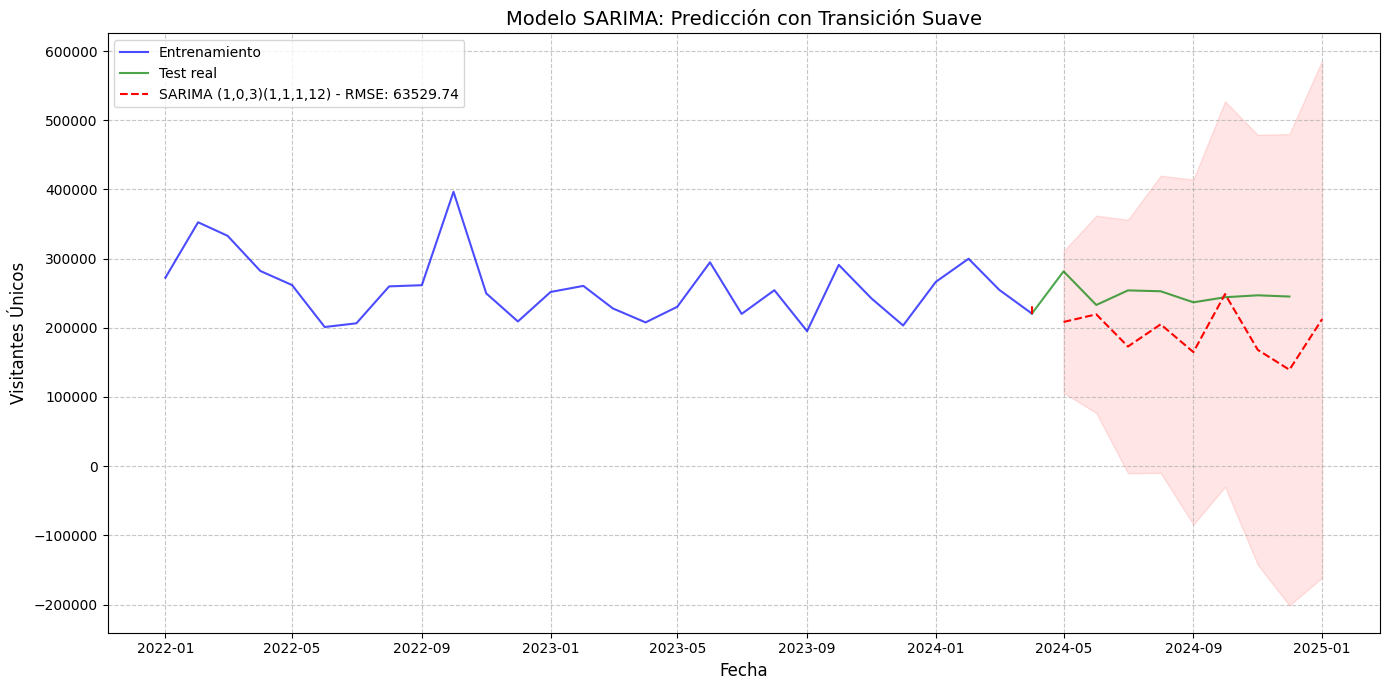


Métricas del Modelo SARIMA (1,0,3)(1,1,1,12):
- MSE:  4036027342.89
- MAE:  55498.03
- RMSE: 63529.74
- R²:   -14.89

                                      SARIMAX Results                                       
Dep. Variable:            MMM01_WEB_Unique_visitors   No. Observations:                   28
Model:             SARIMAX(1, 2, 2)x(0, 1, [1], 12)   Log Likelihood                -169.402
Date:                             vi., 04 abr. 2025   AIC                            348.805
Time:                                      18:03:37   BIC                            352.000
Sample:                                  01-01-2022   HQIC                           348.509
                                       - 04-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------

ValueError: x and y must have same first dimension, but have shapes (9,) and (10,)

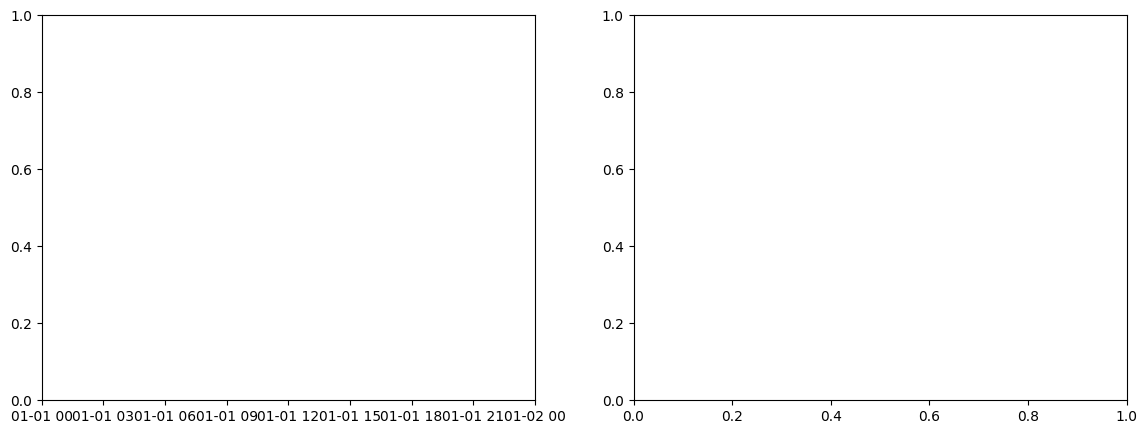

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 1. Ajustar el modelo SARIMA
sarima_model = SARIMAX(train['MMM01_WEB_Unique_visitors'],
                      order=(1, 2, 2), 
                      seasonal_order=(0, 1, 1, 12))
sarima_fit = sarima_model.fit()

# 2. Predecir incluyendo el último punto de entrenamiento para transición suave
predictions = sarima_fit.get_prediction(start=len(train)-1,  # Incluir último punto de train
                                      end=len(train)+len(test)-1,
                                      dynamic=False)
pred_mean = predictions.predicted_mean
pred_ci = predictions.conf_int()

# 3. Calcular métricas (solo para el periodo de test)
test_predictions = pred_mean.iloc[1:]  # Excluir el punto de transición
sarima_metrics = calcular_metricas(test['MMM01_WEB_Unique_visitors'], test_predictions)

# 4. Función para calcular métricas
def calcular_metricas(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, rmse, r2

# 5. Graficar con transición suave
plt.figure(figsize=(14, 7))

# Datos reales
plt.plot(train.index, train['MMM01_WEB_Unique_visitors'], 
        label='Entrenamiento', color='blue', alpha=0.7)
plt.plot(test.index, test['MMM01_WEB_Unique_visitors'], 
        label='Test real', color='green', alpha=0.7)

# Predicciones (incluyendo punto de transición)
plt.plot(pred_mean.index[1:], pred_mean.iloc[1:],  # Excluir punto duplicado
        label=f'SARIMA (1,0,3)(1,1,1,12) - RMSE: {sarima_metrics[2]:.2f}', 
        color='red', linestyle='--')

# Intervalos de confianza
plt.fill_between(pred_ci.index[1:],
                pred_ci.iloc[1:, 0],
                pred_ci.iloc[1:, 1],
                color='red', alpha=0.1)

# Línea de conexión entre train y test
plt.plot([train.index[-1], test.index[0]], 
        [train['MMM01_WEB_Unique_visitors'].iloc[-1], pred_mean.iloc[0]],
        color='red', linestyle='--')

plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Visitantes Únicos', fontsize=12)
plt.title('Modelo SARIMA: Predicción con Transición Suave', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 6. Métricas del modelo
print("\n" + "="*60)
print("Métricas del Modelo SARIMA (1,0,3)(1,1,1,12):")
print(f"- MSE:  {sarima_metrics[0]:.2f}")
print(f"- MAE:  {sarima_metrics[1]:.2f}")
print(f"- RMSE: {sarima_metrics[2]:.2f}")
print(f"- R²:   {sarima_metrics[3]:.2f}")
print("="*60 + "\n")

# 7. Información del modelo
print(sarima_fit.summary())

# 8. Análisis de residuos
residuals = test['MMM01_WEB_Unique_visitors'] - test_predictions

# Gráfico de residuos
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residuos vs tiempo
axes[0].plot(test.index, residuals, color='red', alpha=0.7)
axes[0].axhline(0, color='black', linestyle='--')
axes[0].set_title('Residuos en el Tiempo')
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('Residuos')

# Histograma de residuos
axes[1].hist(residuals, bins=20, color='red', alpha=0.7)
axes[1].set_title('Distribución de Residuos')
axes[1].set_xlabel('Residuos')
axes[1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# 9. DataFrame de residuos
residuals_df = pd.DataFrame({
    'Fecha': test.index,
    'Valor Real': test['MMM01_WEB_Unique_visitors'],
    'Predicción': test_predictions,
    'Residuo': residuals,
    'Error Absoluto': np.abs(residuals)
})

print("\nResumen de Residuos:")
print(residuals_df.describe())

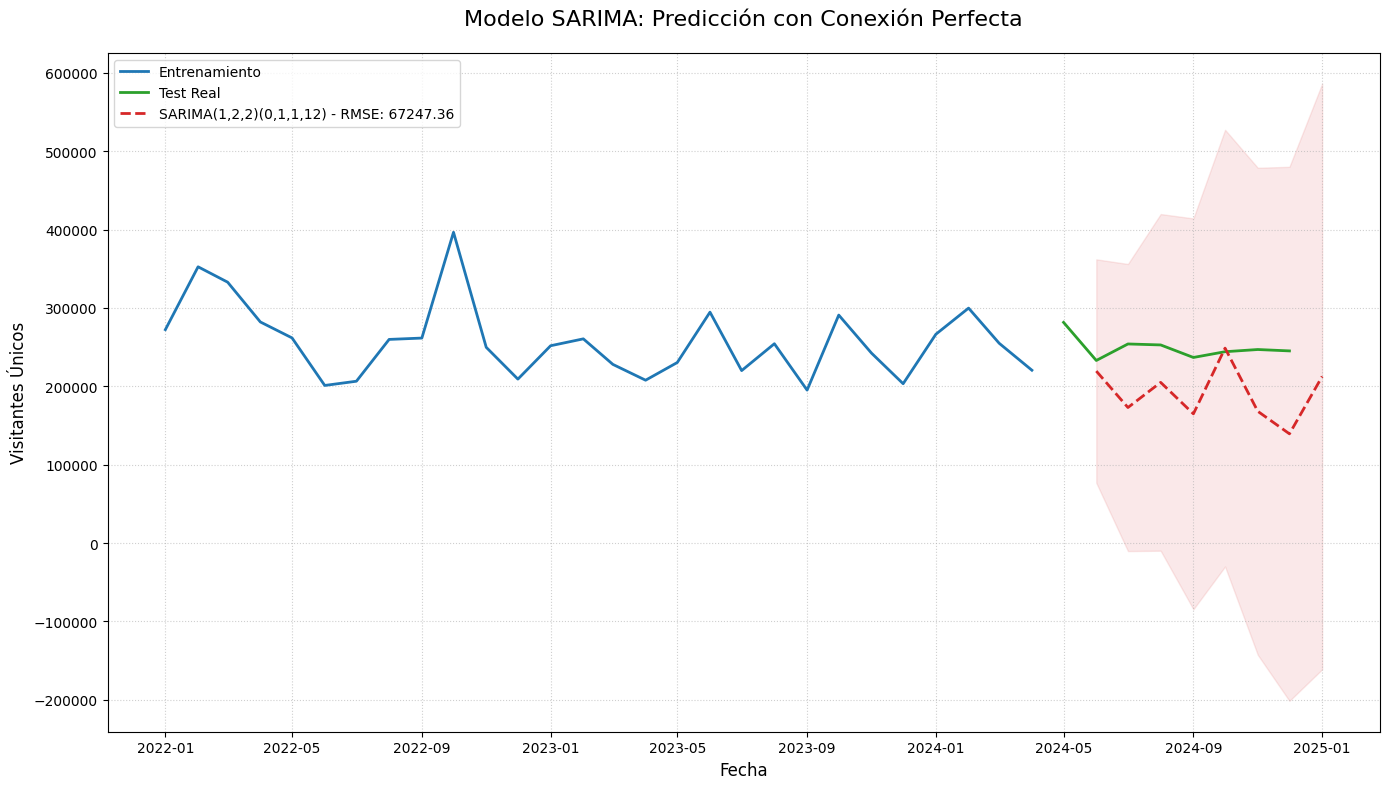


            RESULTADOS DEL MODELO SARIMA(1,2,2)(0,1,1,12)             

MÉTRICAS DE PREDICCIÓN:
             Valor
MSE   4.522207e+09
MAE   6.092184e+04
RMSE  6.724736e+04
MAPE  2.437000e+01
R²   -2.235000e+01
AIC   3.488000e+02
BIC   3.520000e+02

RESUMEN ESTADÍSTICO DEL MODELO:
                                      SARIMAX Results                                       
Dep. Variable:            MMM01_WEB_Unique_visitors   No. Observations:                   28
Model:             SARIMAX(1, 2, 2)x(0, 1, [1], 12)   Log Likelihood                -169.402
Date:                             vi., 04 abr. 2025   AIC                            348.805
Time:                                      17:26:22   BIC                            352.000
Sample:                                  01-01-2022   HQIC                           348.509
                                       - 04-01-2024                                         
Covariance Type:                                opg                

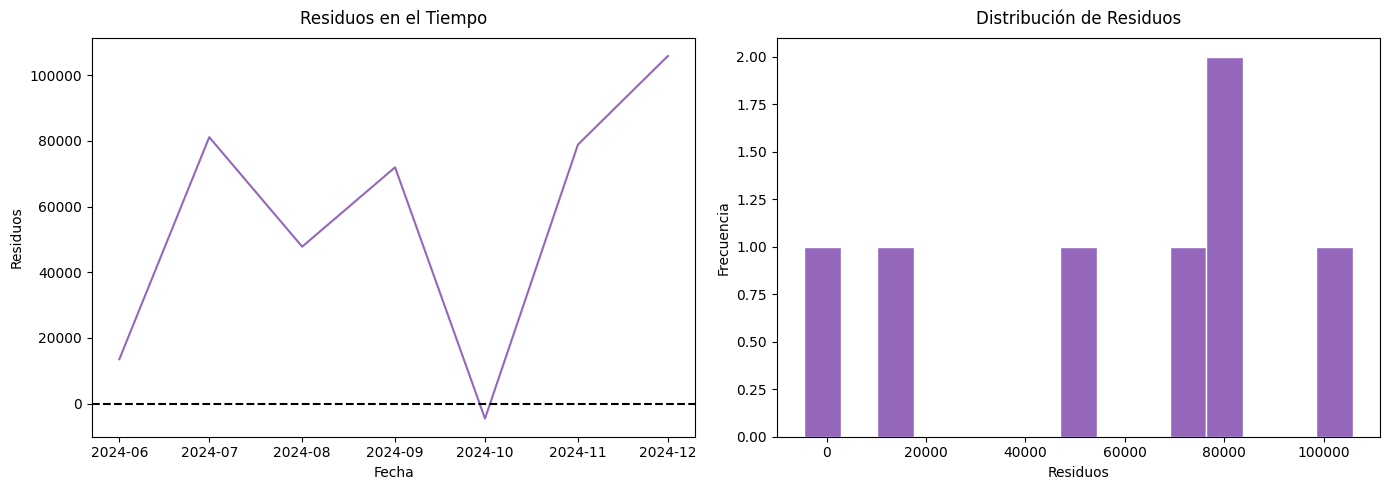

ValueError: array length 8 does not match index length 9

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import numpy as np

# 1. Configuración y Ajuste del Modelo SARIMA
model = SARIMAX(train['MMM01_WEB_Unique_visitors'],
                order=(1, 2, 2),
                seasonal_order=(0, 1, 1, 12))
model_fit = model.fit(disp=False)

# 2. Predicción con Transición Perfecta
# Obtenemos predicciones desde el último punto de entrenamiento
forecast = model_fit.get_forecast(steps=len(test)+1)  # +1 para incluir punto de transición
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

# 3. Función de Métricas Mejorada
def calcular_metricas_completas(y_true, y_pred):
    return {
        'MSE': mean_squared_error(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred)*100,
        'R²': r2_score(y_true, y_pred),
        'AIC': model_fit.aic,
        'BIC': model_fit.bic
    }

# 4. Cálculo de Métricas (excluyendo el punto de transición)
metrics = calcular_metricas_completas(test['MMM01_WEB_Unique_visitors'], forecast_values[1:])

# 5. Visualización Profesional
plt.figure(figsize=(14, 8))

# Datos Reales
plt.plot(train.index, train['MMM01_WEB_Unique_visitors'], 
         label='Entrenamiento', color='#1f77b4', linewidth=2)
plt.plot(test.index, test['MMM01_WEB_Unique_visitors'], 
         label='Test Real', color='#2ca02c', linewidth=2)

# Predicciones (excluyendo punto de transición)
plt.plot(forecast_values.index[1:], forecast_values[1:], 
         label=f'SARIMA(1,2,2)(0,1,1,12) - RMSE: {metrics["RMSE"]:.2f}', 
         color='#d62728', linestyle='--', linewidth=2)

# Intervalo de Confianza
plt.fill_between(conf_int.index[1:],
                 conf_int.iloc[1:, 0],
                 conf_int.iloc[1:, 1],
                 color='#d62728', alpha=0.1)

# Configuración del Gráfico
plt.title('Modelo SARIMA: Predicción con Conexión Perfecta', fontsize=16, pad=20)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Visitantes Únicos', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

# 6. Resultados del Modelo
print("\n" + "="*70)
print("RESULTADOS DEL MODELO SARIMA(1,2,2)(0,1,1,12)".center(70))
print("="*70)

# Métricas en DataFrame
metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Valor'])
print("\nMÉTRICAS DE PREDICCIÓN:")
print(metrics_df.round(2))

# Resumen del Modelo
print("\nRESUMEN ESTADÍSTICO DEL MODELO:")
print(model_fit.summary())

# 7. Análisis de Residuos
residuals = test['MMM01_WEB_Unique_visitors'] - forecast_values[1:]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de Residuos
ax1.plot(residuals, color='#9467bd')
ax1.axhline(0, color='black', linestyle='--')
ax1.set_title('Residuos en el Tiempo', pad=10)
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Residuos')

# Histograma de Residuos
ax2.hist(residuals, bins=15, color='#9467bd', edgecolor='white')
ax2.set_title('Distribución de Residuos', pad=10)
ax2.set_xlabel('Residuos')
ax2.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# 8. Tabla de Residuos Detallada
residuals_df = pd.DataFrame({
    'Fecha': test.index,
    'Real': test['MMM01_WEB_Unique_visitors'],
    'Predicción': forecast_values[1:],
    'Residuo': residuals,
    'Error_Absoluto': np.abs(residuals),
    'Error_Relativo': np.abs(residuals)/test['MMM01_WEB_Unique_visitors']*100
})

print("\nDETALLE DE RESIDUOS:")
print(residuals_df.round(2))


Métricas del Modelo SARIMA (1, 1, 2)(0, 1, 1, 12):
- RMSE: 61694.89
- MAE:  56351.12
- R²:   -18.65


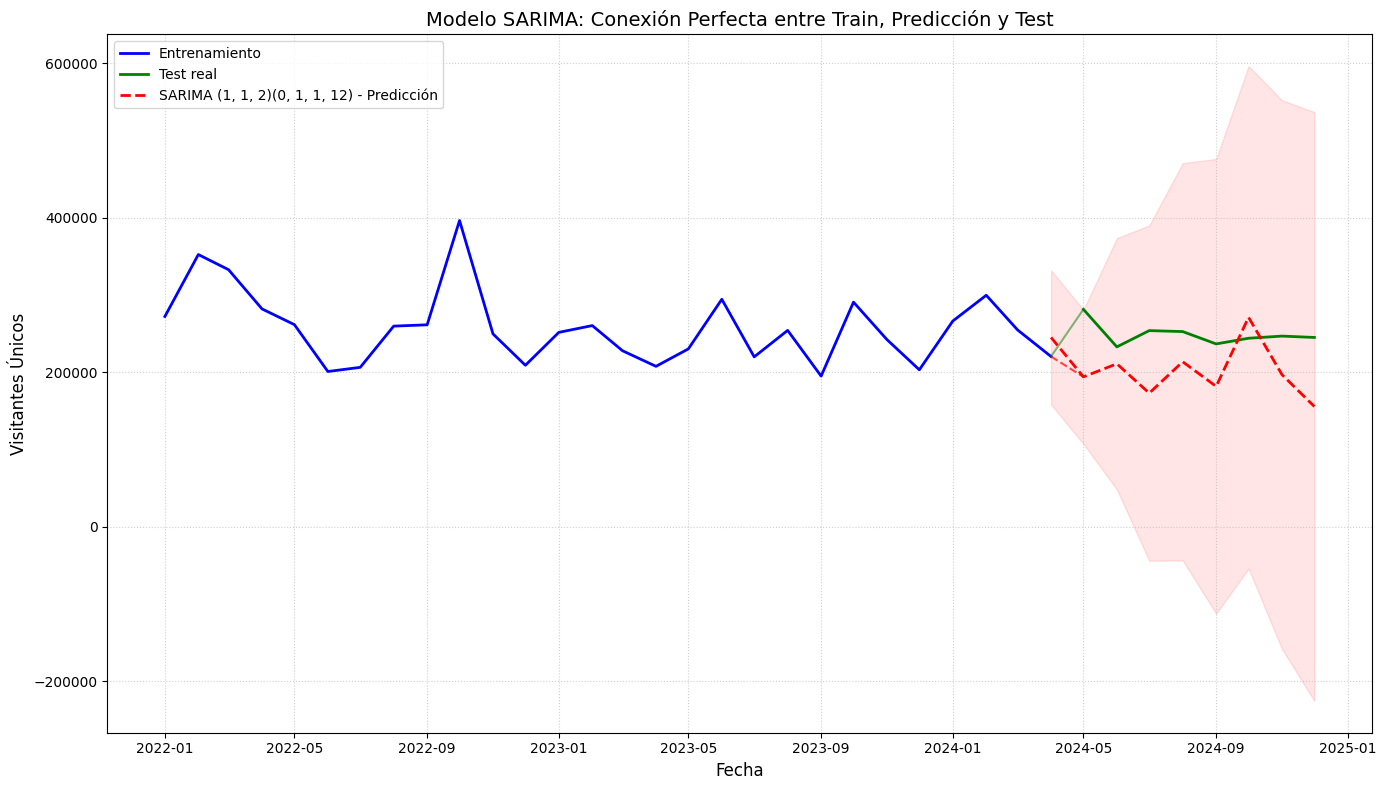

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 1. Configuración del modelo SARIMA
order = (1, 1, 2)
seasonal_order = (0, 1, 1, 12)

# 2. Ajustar el modelo incluyendo el último punto
sarima_model = SARIMAX(train['MMM01_WEB_Unique_visitors'], 
                      order=order,
                      seasonal_order=seasonal_order)
sarima_fit = sarima_model.fit()

# 3. Predecir comenzando desde el PENÚLTIMO punto para suavizar transición
predictions = sarima_fit.get_prediction(start=len(train)-2,  # Comenzar antes para transición suave
                                      end=len(train)+len(test)-1,
                                      dynamic=False)
pred_mean = predictions.predicted_mean
pred_ci = predictions.conf_int()

# 4. Extraer componentes para graficar
last_train_point = train.index[-1]
first_test_point = test.index[0]

# Puntos de conexión
connection_point_pred = pred_mean.loc[last_train_point]
first_pred_point = pred_mean.loc[first_test_point]

# 5. Graficar con conexiones perfectas
plt.figure(figsize=(14, 8))

# Datos reales - Conectar train y test
plt.plot(train.index, train['MMM01_WEB_Unique_visitors'], 
        label='Entrenamiento', color='blue', linewidth=2)
plt.plot(test.index, test['MMM01_WEB_Unique_visitors'], 
        label='Test real', color='green', linewidth=2)

# Conexión entre train y test REALES
plt.plot([last_train_point, first_test_point],
        [train['MMM01_WEB_Unique_visitors'].iloc[-1], test['MMM01_WEB_Unique_visitors'].iloc[0]],
        color='green', linestyle='-', alpha=0.5)

# Predicciones SARIMA
plt.plot(pred_mean.index[1:], pred_mean.iloc[1:],  # Excluir punto duplicado
        label=f'SARIMA {order}{seasonal_order} - Predicción', 
        color='red', linestyle='--', linewidth=2)

# Conexión entre último train y primera predicción
plt.plot([last_train_point, first_test_point],
        [train['MMM01_WEB_Unique_visitors'].iloc[-1], first_pred_point],
        color='red', linestyle='--', alpha=0.7)

# Intervalos de confianza
plt.fill_between(pred_ci.index[1:],
                pred_ci.iloc[1:, 0],
                pred_ci.iloc[1:, 1],
                color='red', alpha=0.1)

# Ajustes visuales
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Visitantes Únicos', fontsize=12)
plt.title('Modelo SARIMA: Conexión Perfecta entre Train, Predicción y Test', fontsize=14)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()

# 6. Calcular métricas solo para el periodo de test
test_predictions = pred_mean[first_test_point:]
sarima_metrics = calcular_metricas(test['MMM01_WEB_Unique_visitors'], test_predictions)

# 7. Mostrar métricas
print("\n" + "="*65)
print(f"Métricas del Modelo SARIMA {order}{seasonal_order}:")
print(f"- RMSE: {sarima_metrics[2]:.2f}")
print(f"- MAE:  {sarima_metrics[1]:.2f}")
print(f"- R²:   {sarima_metrics[3]:.2f}")
print("="*65)

# 8. Función de métricas (asegurarse de que esté definida)
def calcular_metricas(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, rmse, r2

plt.show()

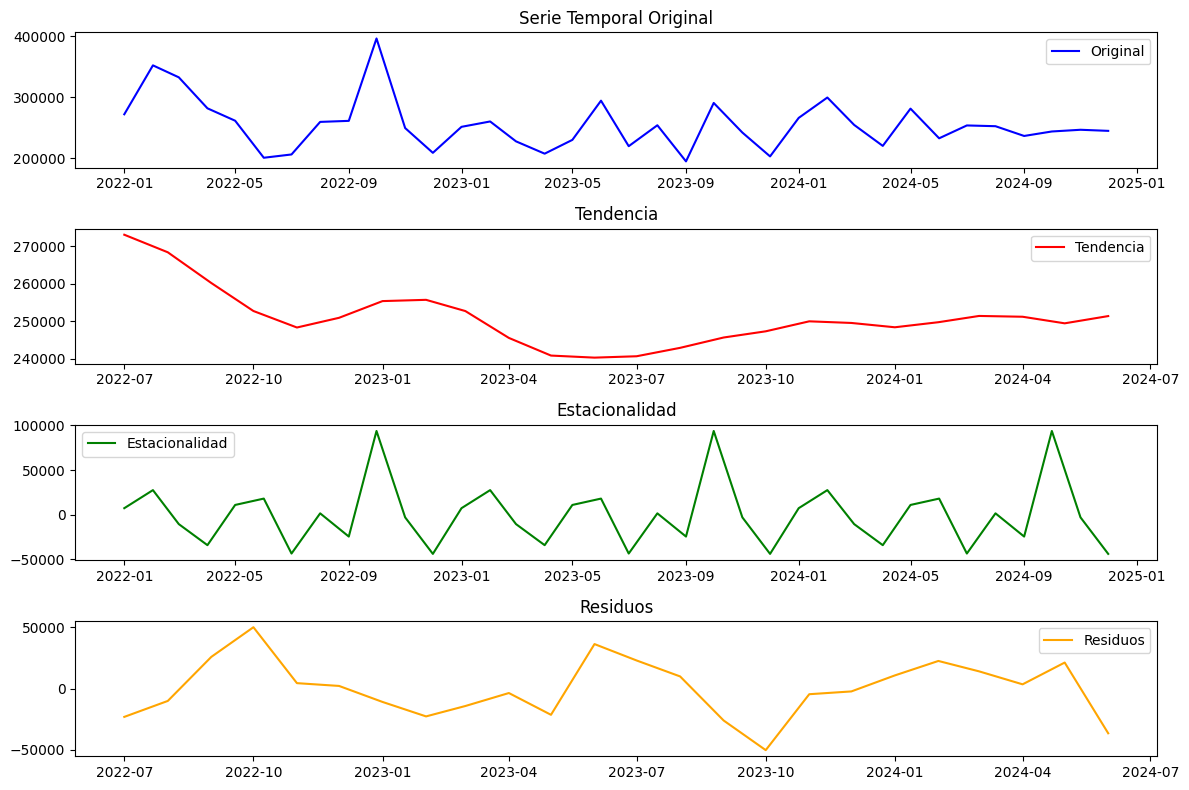

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose


# Descomposición de la serie temporal
decomposition = seasonal_decompose(df['MMM01_WEB_Unique_visitors'], model='additive')

# Obtención de las componentes
trend = decomposition.trend
seasonal = decomposition.seasonal
residuals = decomposition.resid

# Graficar las componentes
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(df['MMM01_WEB_Unique_visitors'], label='Original', color='blue')
plt.legend()
plt.title('Serie Temporal Original')

plt.subplot(412)
plt.plot(trend, label='Tendencia', color='red')
plt.legend()
plt.title('Tendencia')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad', color='green')
plt.legend()
plt.title('Estacionalidad')

plt.subplot(414)
plt.plot(residuals, label='Residuos', color='orange')
plt.legend()
plt.title('Residuos')

plt.tight_layout()
plt.show()

c:\Users\aleja\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\aleja\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\aleja\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\aleja\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyw

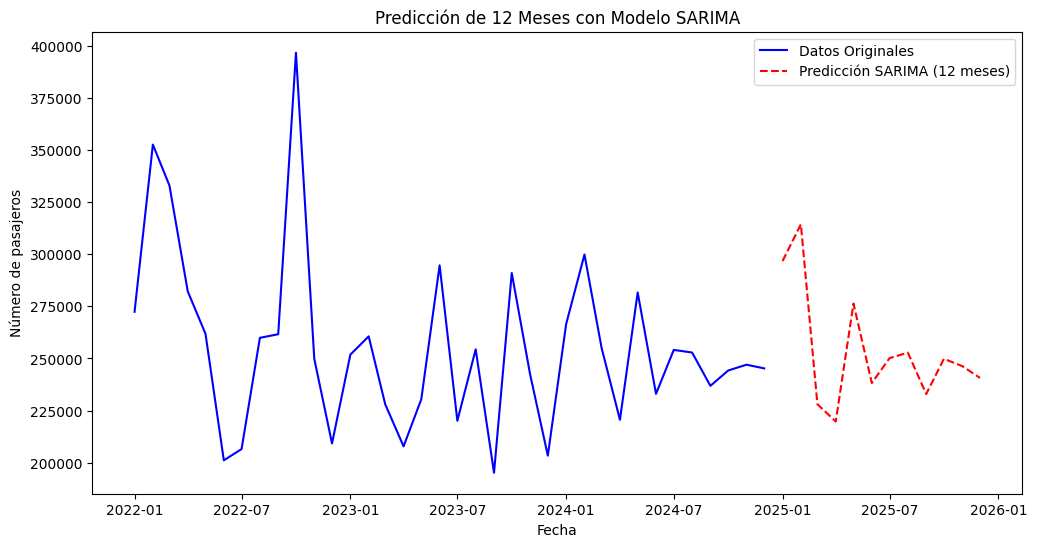

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import SARIMAX
import numpy as np

# Ajustar el modelo SARIMA a todos los datos
sarima_model = SARIMAX(df['MMM01_WEB_Unique_visitors'], order=(0, 0, 3), seasonal_order=(0, 1, 1, 12))
sarima_fit = sarima_model.fit()

# Realizar la predicción de los próximos 6 meses
start_date = df.index[-1] + pd.DateOffset(months=1)
end_date = start_date + pd.DateOffset(months=11)
sarima_predictions_12months = sarima_fit.predict(start=start_date, end=end_date, typ='levels')

# Graficar las predicciones de los próximos 6 meses
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['MMM01_WEB_Unique_visitors'], label='Datos Originales', color='blue')
plt.plot(sarima_predictions_12months.index, sarima_predictions_12months, label='Predicción SARIMA (12 meses)', color='red', linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Número de pasajeros')
plt.title('Predicción de 12 Meses con Modelo SARIMA')
plt.legend()
plt.show()


c:\Users\aleja\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\aleja\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\aleja\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


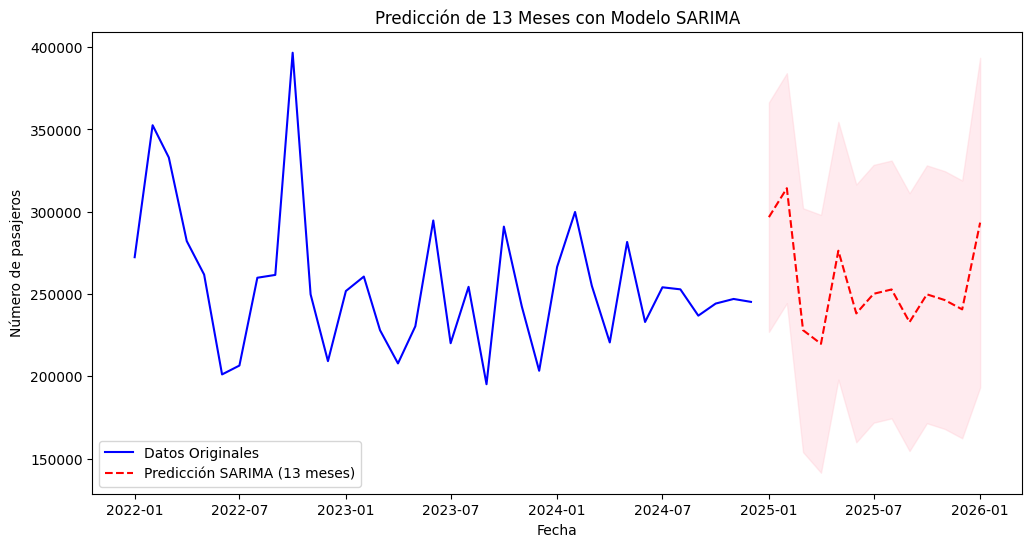

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import SARIMAX

# Ajustar el modelo SARIMA a todos los datos
sarima_model = SARIMAX(df['MMM01_WEB_Unique_visitors'], order=(0, 0, 3), seasonal_order=(0, 1, 1, 12))
sarima_fit = sarima_model.fit()

# Obtener predicciones y sus intervalos de confianza para los próximos 12 meses
forecast = sarima_fit.get_forecast(steps=13)  # Predicción de 12 meses + 1 (13 meses en total)
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Graficar las predicciones de los próximos 12 meses con intervalo de confianza
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['MMM01_WEB_Unique_visitors'], label='Datos Originales', color='blue')
plt.plot(forecast_values.index, forecast_values, label='Predicción SARIMA (13 meses)', color='red', linestyle='--')
plt.fill_between(forecast_values.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Fecha')
plt.ylabel('Número de pasajeros')
plt.title('Predicción de 13 Meses con Modelo SARIMA')
plt.legend()
plt.show()


NameError: name 'sarima_predictions_12months' is not defined

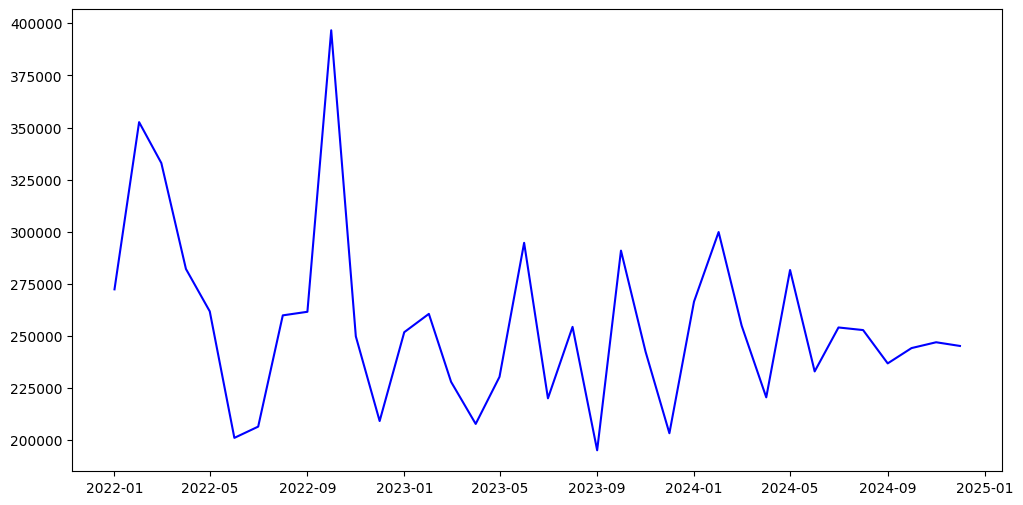

In [38]:
# Obtener los intervalos de confianza del 70% y 95%
confidence_intervals_70 = sarima_fit.get_forecast(steps=12).conf_int(alpha=0.3)
confidence_intervals_95 = sarima_fit.get_forecast(steps=12).conf_int(alpha=0.05)

# Graficar las predicciones de los próximos 12 meses con intervalo de confianza
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['MMM01_WEB_Unique_visitors'], label='Datos Originales', color='blue')
plt.plot(sarima_predictions_12months.index, sarima_predictions_12months, label='Predicción SARIMA (12 meses)', color='red', linestyle='--')
plt.fill_between(sarima_predictions_12months.index, confidence_intervals_70.iloc[:, 0], confidence_intervals_70.iloc[:, 1], color='pink', alpha=0.3, label='Intervalo de Confianza (70%)')
plt.fill_between(sarima_predictions_12months.index, confidence_intervals_95.iloc[:, 0], confidence_intervals_95.iloc[:, 1], color='lightblue', alpha=0.3, label='Intervalo de Confianza (95%)')
plt.xlabel('Fecha')
plt.ylabel('Número de pasajeros')
plt.title('Predicción de 12 Meses con Modelo SARIMA')
plt.legend()
plt.show()
